In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print('This notebook is not stale yet!')

This notebook is not stale yet!


In [16]:
# Test with the coastline flat
ntot_cf = 1 # goes from 1-8
D_full_cf = 50*u.mm
ca_80 = 80
oversamp_size = 4096
dr_width = 5
npix_diam_cf = []
var_cf = []

for ntest in range(0,ntot_cf):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/coastline_flat_correct.fits'
    surf_data = fits.getdata(surf_loc)*u.um

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_cf, ca_80, oversamp_size)

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_cf)

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test: {}'.format(np.sum(norm_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)

    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_cf = np.zeros((ntot_cf, np.shape(kval)[0]))
        mean_psd_cf = np.zeros((ntot_cf, np.shape(mean_val)[0]))

    kval_cf[ntest,:] = copy.copy(kval)
    mean_psd_cf[ntest,:] = copy.copy(mean_val)
    npix_diam_cf.append(npix_diam)
    var_cf.append(ap_var)

# force in the units, they will be the same across each iteration
kval_cf *= kval.unit
mean_psd_cf *= mean_val.unit
var_cf *= ap_var.unit

PSD normalized: var=1.000
var test: 0.9999999999999998
Finished calculating PSD for surface 0


Text(0, 0.5, 'Surface PSD [mm2] (variance normalized)')

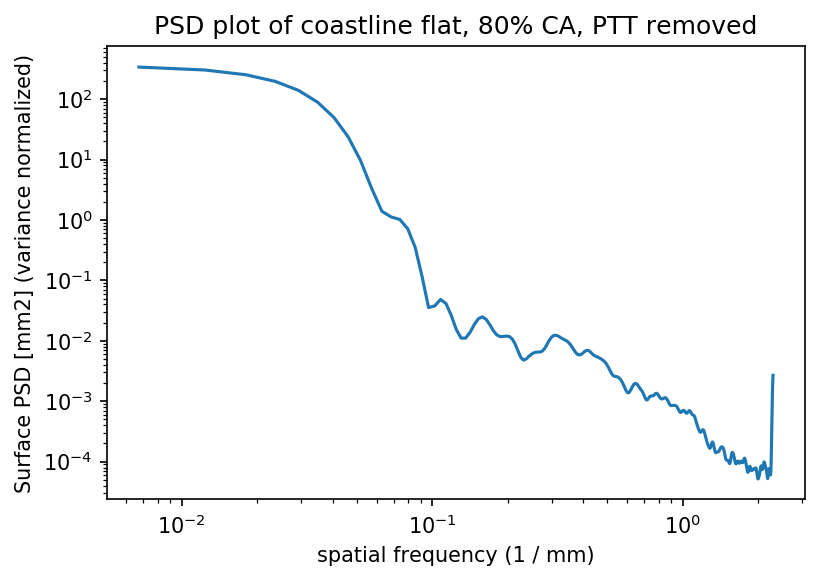

In [24]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
n_surf = 0
plt.figure(dpi=150)
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
for ns in range(0,ntot_cf):
    #plt.loglog(kval_cf[n_surf,:], mean_psd_cf[n_surf,:])
    plt.loglog(kval_cf[ns].value, mean_psd_cf[ns].value)
plt.title('PSD plot of coastline flat, 80% CA, PTT removed')
plt.xlabel('spatial frequency ({})'.format(kval_cf.unit))
plt.ylabel('Surface PSD [{}] (variance normalized)'.format(mean_psd_cf.unit)) 

In [2]:
# 2 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 50.8*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 2 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
    print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
    print('var at n{}: {:.3f}'.format(ntest+1, ap_var))

    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)
    print('delta k at n{}: {:.5f}'.format(ntest+1, delta_k))

    norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    print('var test n{}: {:.3f}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))
    cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
    print('cal var test n{}: {:.3f}'.format(ntest+1, np.sum(cal_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    #(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
    (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, D_full_1, ca_80)
    print('norm PSD units n{}: {}'.format(ntest+1, mv_n.unit)) # should be mm2
    print('cal PSD units n{}: {}'.format(ntest+1, mv_c.unit))  # should be mm2 nm2

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mn_psd_1 = np.zeros((ntot_1, np.shape(mv_n)[0]))
        mc_psd_1 = np.zeros((ntot_1, np.shape(mv_c)[0]))

    kval_1[ntest,:] = copy.copy(kval)
    mn_psd_1[ntest,:] = copy.copy(mv_n)
    mc_psd_1[ntest,:] = copy.copy(mv_c)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)
    surf_pwr_1[ntest,:,:] = copy.copy(pwr_opt)

# force in the units, they will be the same across each iteration
kval_1 *= kval.unit
mn_psd_1 *= mv_n.unit
mc_psd_1 *= mv_c.unit
var_1 *= ap_var.unit
surf_pwr_1 *= pwr_opt.unit

print('All PSD measurement tests done, begin calculating average PSD')

# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_1 = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_1[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
avg_psd_1 *= mn_psd_1.unit
    
# Step 4: scale the average PSD by the average of collection of individual variances in step 1
avg_cal_psd = avg_psd_1 * avg_tot_var

print('Finished calculating average PSD surface')

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1)

Crunching individual PSDs for 2 inch flats (8 total mirrors)
surf unit at n1: mm
var at n1: 6.376 nm2
delta k at n1: 0.00270 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 6.376 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
surf unit at n2: mm
var at n2: 16.486 nm2
delta k at n2: 0.00270 1 / mm
PSD normalized: var=1.000
var test n2: 1.000
cal var test n2: 16.486 nm2
norm PSD units n2: mm2
cal PSD units n2: mm2 nm2
Finished calculating PSD for surface 2
surf unit at n3: mm
var at n3: 1.347 nm2
delta k at n3: 0.00270 1 / mm
PSD normalized: var=1.000
var test n3: 1.000
cal var test n3: 1.347 nm2
norm PSD units n3: mm2
cal PSD units n3: mm2 nm2
Finished calculating PSD for surface 3
surf unit at n4: mm
var at n4: 25.868 nm2
delta k at n4: 0.00270 1 / mm
PSD normalized: var=1.000
var test n4: 1.000
cal var test n4: 25.868 nm2
norm PSD units n4: mm2
cal PSD units n4: mm2 nm2
Finished calculating PSD for surface 4
surf unit a

In [16]:
1/(0.8*D_full_1)

<Quantity 0.0246063 1 / mm>

In [18]:
k_ll = 0.1/u.mm
ca_new = 1/(k_ll*D_full_1)
ca_new, ca_new*D_full_1

(<Quantity 0.19685039>, <Quantity 10. mm>)

In [4]:
np.amin(kval_1)

<Quantity 0.02703329 1 / mm>

In [5]:
np.amax(FT_freq)

<Quantity 5.53371399 1 / mm>

In [6]:
np.amax(kval_1)

<Quantity 5.52830734 1 / mm>

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

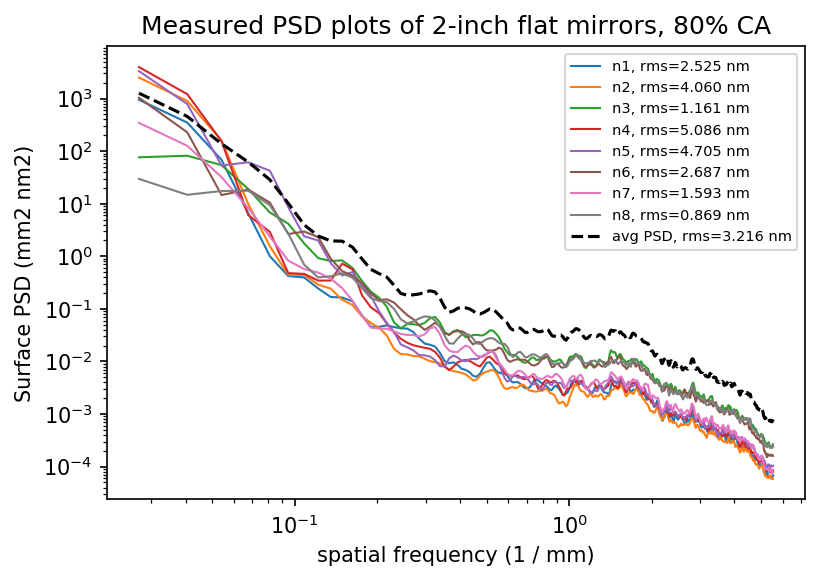

In [7]:
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

In [8]:
print('All PSD measurement tests done, begin calculating average PSD')

# generate the average PSD
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1

# Step 3: Take average of collection of data calibrated PSDs
avg_psd_new = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_new[i] = np.sum(mc_psd_1[:,i].value)/np.shape(mc_psd_1)[0]
avg_psd_new *= mc_psd_1.unit
    
# Step 4: scale the average PSD by the average of collection of individual variances in step 1
#avg_cal_psd_new = avg_psd_new * avg_tot_var


All PSD measurement tests done, begin calculating average PSD


Text(0, 0.5, 'Surface PSD (mm2 nm2)')

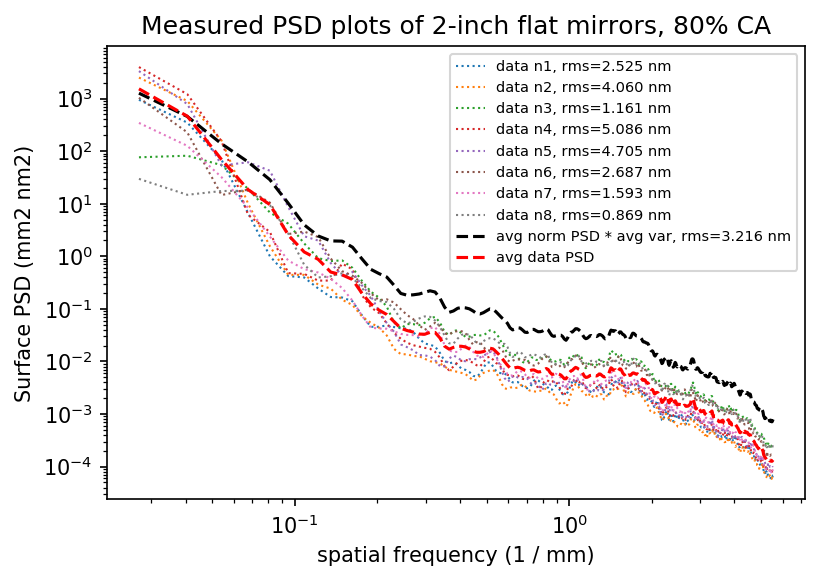

In [12]:
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], ':', label='data n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg norm PSD * avg var, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.loglog(kval_1[0,:], avg_psd_new, 'r--', label='avg data PSD')
plt.title('Measured PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

In [110]:
1/(oversamp_size * ((ca_80/100)*D_full_1) / npix_diam_1[0])

<Quantity 0.00270333 1 / mm>

In [111]:
delta_k

<Quantity 0.00270333 1 / mm>

In [114]:
(oversamp_size/2) * delta_k

<Quantity 5.53641732 1 / mm>

In [98]:
# norm PSD calc
# Step 0: initialize variables
avg_cal_psd_set = np.zeros((ntot_1, nkval))

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# mn_psd_1

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_1 = np.zeros((nkval))
for i in range(0,nkval):
    avg_psd_1[i] = np.sum(mn_psd_1[:,i].value)/np.shape(mn_psd_1)[0]
avg_psd_1 *= mn_psd_1.unit
    
# Step 4: scale the average PSD by the collection of individual variances in step 1
for i in range(0,ntot_1):
    avg_cal_psd_set[i,:] = avg_psd_1 * var_1[i]
avg_cal_psd_set *= avg_psd_1.unit * var_1.unit
avg_cal_psd = avg_psd_1 * avg_tot_var # this is the average one

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1)

In [99]:
avg_cal_psd_set

<Quantity [[1.29392475e+03, 6.54672145e+02, 2.19046572e+02, ...,
            4.44537045e-04, 4.59807944e-04, 4.78546116e-04],
           [3.34564317e+03, 1.69275639e+03, 5.66378894e+02, ...,
            1.14941949e-03, 1.18890477e-03, 1.23735522e-03],
           [2.73419489e+02, 1.38338897e+02, 4.62867734e+01, ...,
            9.39352086e-05, 9.71621053e-05, 1.01121672e-04],
           ...,
           [1.46492845e+03, 7.41192912e+02, 2.47995532e+02, ...,
            5.03286582e-04, 5.20575667e-04, 5.41790256e-04],
           [5.15219997e+02, 2.60679905e+02, 8.72208174e+01, ...,
            1.77007492e-04, 1.83088118e-04, 1.90549356e-04],
           [1.53357783e+02, 7.75926644e+01, 2.59617081e+01, ...,
            5.26871564e-05, 5.44970849e-05, 5.67179594e-05]] mm2 nm2>

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

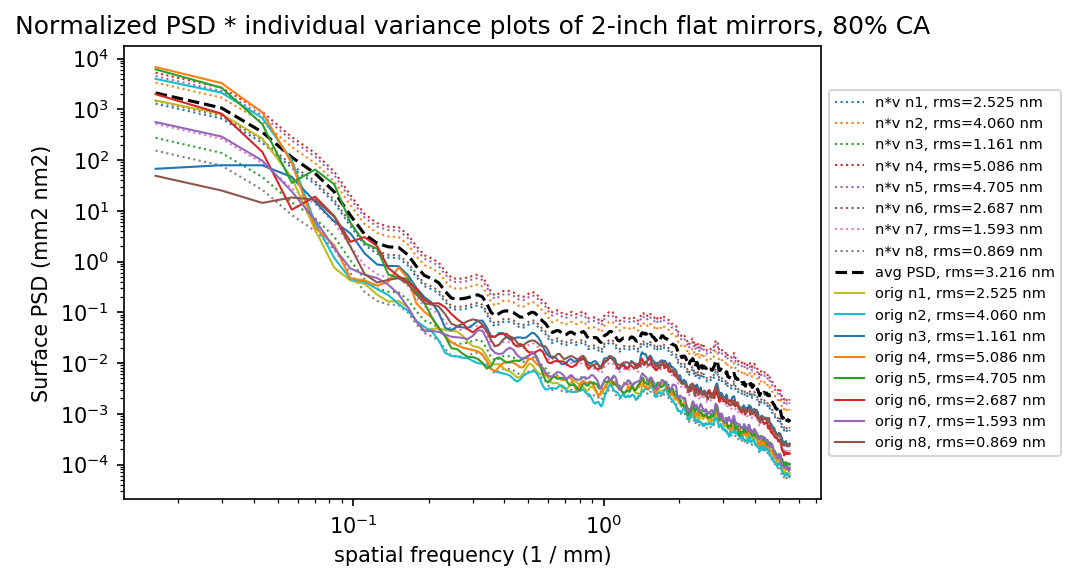

In [103]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], avg_cal_psd_set[ns,:], ':', label='n*v n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='orig n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.title('Normalized PSD * individual variance plots of 2-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(avg_cal_psd_set.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

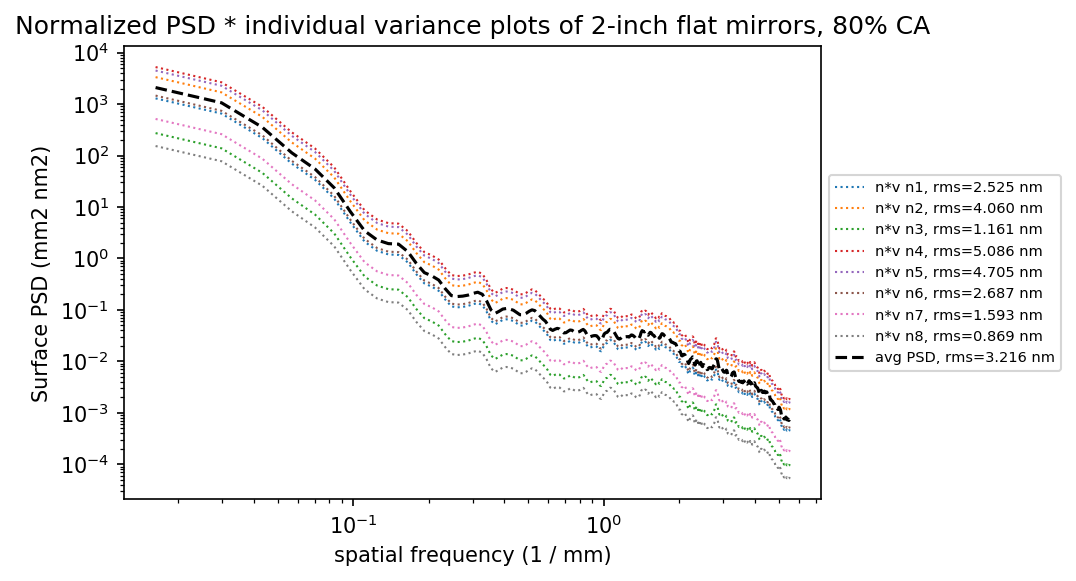

In [104]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], avg_cal_psd_set[ns,:], ':', label='n*v n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
#for ns in range(0,ntot_1):
#    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='orig n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.title('Normalized PSD * individual variance plots of 2-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(avg_cal_psd_set.unit)) 

In [63]:
def calc_hannWin(optic, full_diam, ca_percent, ovs):
    surf_units = optic.unit
    optic = optic.value
    # check if the optics are same shape. 
    # If the data is not square, pick the shortest side for npix_diam
    if np.shape(optic)[0] <= np.shape(optic)[1]:
        side_diam = np.shape(optic)[0]
    else:
        side_diam = np.shape(optic)[1]
    
    # verify the data to be even, square matrix
    if (np.shape(optic)[0] != np.shape(optic)[1]) or (np.shape(optic)[0] % 2 != 0):
        optic_data = psd.adjustData(optic)
    else:
        optic_data = optic

    # Create the clear aperture mask based on the clear aperture percent
    data_side = np.shape(optic_data)[0]
    npix_diam = np.int(side_diam*ca_percent/100)
    # npix_diam must be even to get the padding to work correctly
    if npix_diam %2 != 0: # if odd
        npix_diam -= 1 # decrease by 1 to force to even
    ap_clear = np.zeros((data_side, data_side), dtype=np.uint8)
    ca_coords = draw.circle(data_side/2, data_side/2, radius=(npix_diam/2))
    ap_clear[ca_coords] = True

    # calculate the mean and variance of the active region of data
    ap_active = optic_data * ap_clear
    ap_active_coords = optic_data[ap_clear==True]
    ap_avg = np.mean(ap_active_coords)
    ap_var = np.var(ap_active_coords)*surf_units*surf_units

    # Subtract the mean from the data
    ap_submean = (ap_active - ap_avg) * ap_clear

    # build the Hann 2D window
    hannWin = psd.han2d((npix_diam, npix_diam))
    # zero-pad the window to fit with the full aperture dimensions
    pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
    pad_hann = np.pad(hannWin, pad_side, mf.pad_with) * ap_clear
    
    hann_ap = pad_hann* ap_submean
    
    return hann_ap, ap_clear, ap_submean, ap_avg, ap_var

surf unit at n8: mm


Text(0.5, 1.0, '2-inch windowed 80% CA, n8, rms = 0.869 nm')

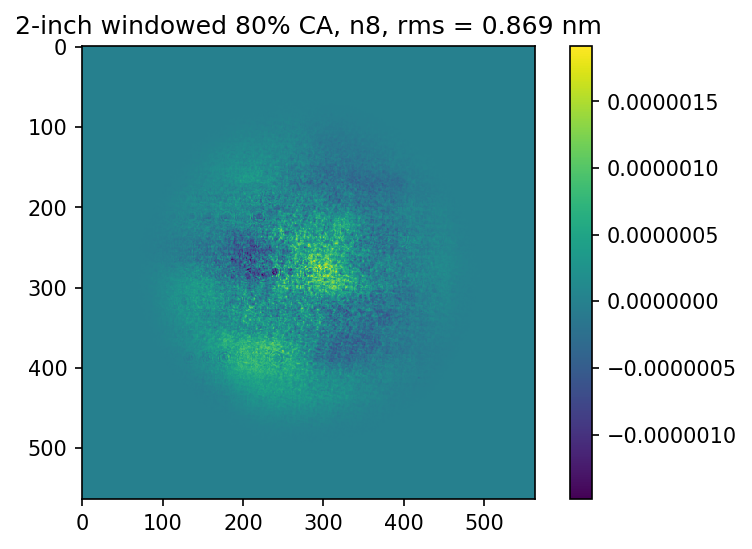

In [82]:
ntest=7
surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

win_submean, ap_clear, ap_submean, ap_avg, ap_var = calc_hannWin(surf_data, D_full_1, ca_80, oversamp_size)

plt.figure(dpi=150)
plt.imshow(win_submean*ap_clear)
plt.colorbar()
plt.title('2-inch windowed 80% CA, n{}, rms = {:.3f}'.format(ntest+1, np.sqrt(ap_var)*1e6*u.nm/u.mm))

surf unit at n8: mm


Text(0.5, 1.0, '2-inch windowed 80% CA, n8, rms = 0.869 nm')

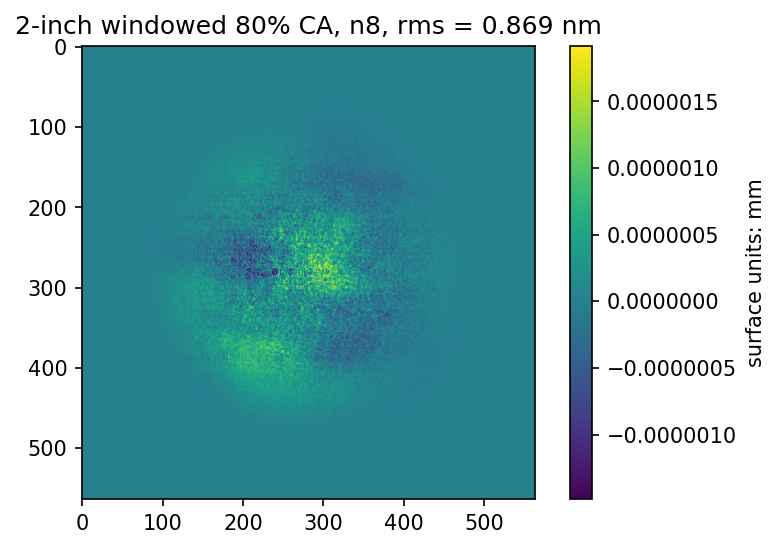

In [90]:
ntest=7
surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

win_submean, ap_clear, ap_submean, ap_avg, ap_var = calc_hannWin(surf_data, D_full_1, ca_80, oversamp_size)

plt.figure(dpi=150)
plt.imshow(win_submean)
plt.colorbar().set_label('surface units: {}'.format(surf_data.unit))
plt.title('2-inch windowed 80% CA, n{}, rms = {:.3f}'.format(ntest+1, np.sqrt(ap_var)*1e6*u.nm/u.mm))

surf unit at n3: mm


Text(0.5, 1.0, '1-inch windowed 80% CA, n3, rms = 3.324 nm')

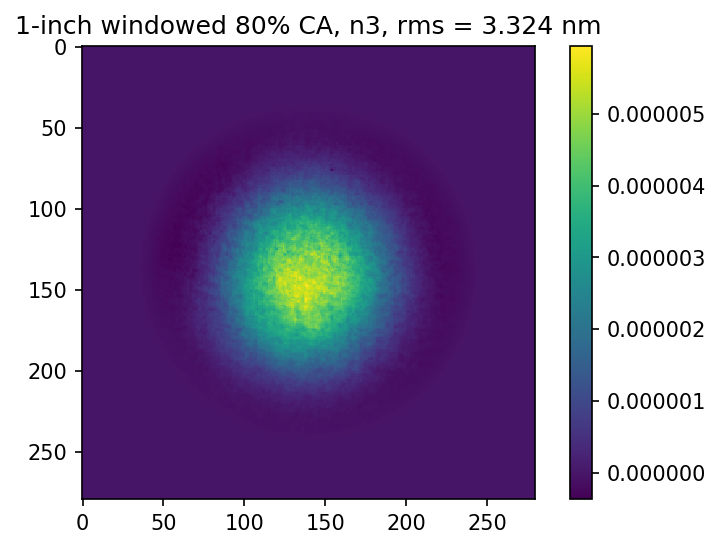

In [86]:
ntest=2
surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert um data to mm
print('surf unit at n{}: {}'.format(ntest+1, surf_data.unit))

win_submean, ap_clear, ap_submean, ap_avg, ap_var = calc_hannWin(surf_data, D_full_1, ca_80, oversamp_size)

plt.figure(dpi=150)
plt.imshow(win_submean)
plt.colorbar()
plt.title('1-inch windowed 80% CA, n{}, rms = {:.3f}'.format(ntest+1, np.sqrt(ap_var)*1e6*u.nm/u.mm))

In [31]:
ap_avg

7.169691472702163e-06

In [33]:
np.sqrt(ap_var)

<Quantity 5.08604934e-06 mm>

In [6]:
np.shape(kval_1)

(8, 408)

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

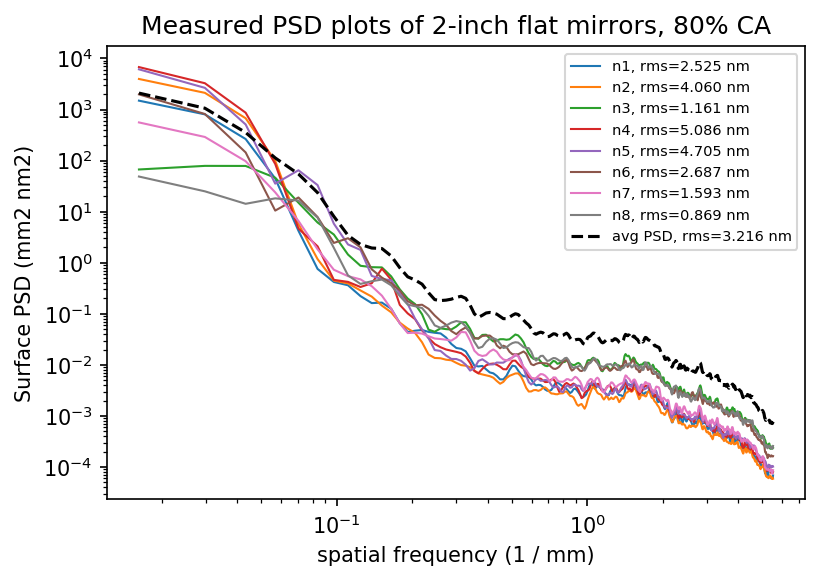

In [8]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

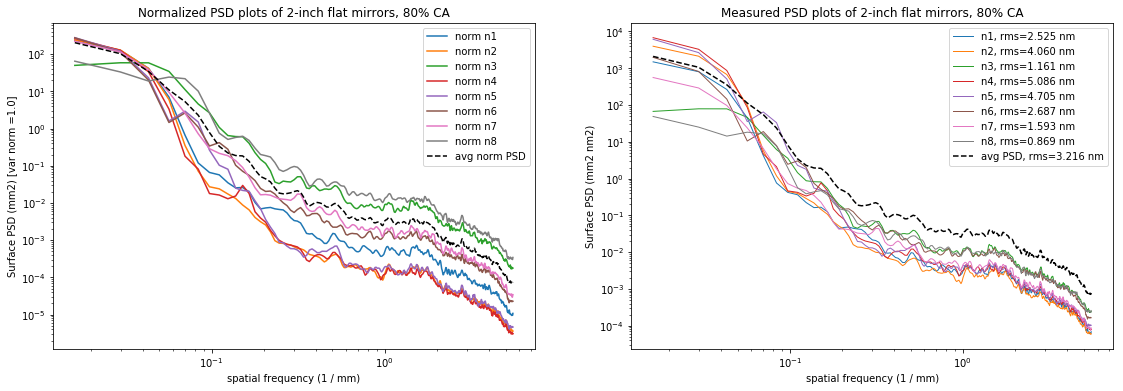

In [5]:
plt.figure(figsize=[19,6])

plt.subplot(1,2,1)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mn_psd_1[ns,:], label='norm n{}'.format(ns+1))
plt.loglog(kval_1[0,:], avg_psd_1, 'k--', label='avg norm PSD')
plt.title('Normalized PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.legend()
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1.unit)) 

plt.subplot(1,2,2)
rms_1 = np.sqrt(var_1)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mc_psd_1[ns,:], label='n{}, rms={:.3f}'.format(ns+1, rms_1[ns]), linewidth=1.0)
plt.loglog(kval_1[0,:], avg_cal_psd, 'k--', label='avg PSD, rms={:.3f}'.format(np.sqrt(avg_tot_var)))
plt.title('Measured PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(prop={'size':7})
plt.legend()
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1.unit)) 

plt.show()

Text(0, 0.5, 'Surface PSD (mm2) [var norm =1.0]')

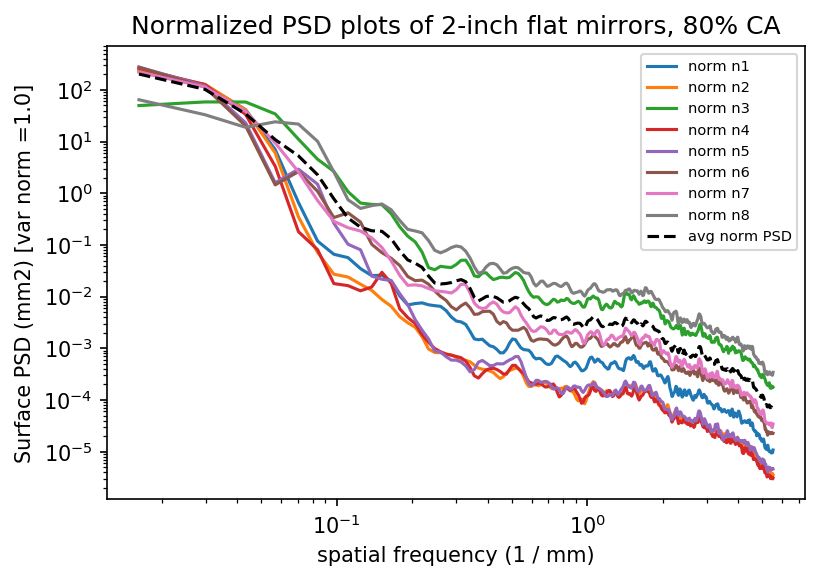

In [118]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], mn_psd_1[ns,:], label='norm n{}'.format(ns+1))
plt.loglog(kval_1[0,:], avg_psd_1, 'k--', label='avg norm PSD')
plt.title('Normalized PSD plots of 2-inch flat mirrors, 80% CA')
#plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1.unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1.unit)) 

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [6]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert to mm
    print('surf unit: {}'.format(surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)

    print('npix_diam at n{}: {}'.format(ntest+1, npix_diam))

Crunching individual PSDs for 1 inch flats (8 total mirrors)
surf unit: mm
npix_diam at n1: 220
surf unit: mm
npix_diam at n2: 220
surf unit: mm
npix_diam at n3: 220
surf unit: mm
npix_diam at n4: 220
surf unit: mm
npix_diam at n5: 220
surf unit: mm
npix_diam at n6: 220
surf unit: mm
npix_diam at n7: 220
surf unit: mm
npix_diam at n8: 220


In [4]:
# 2 inch flats (8 total)

ca_val = 80
dr_width = 5

ntot_2 = 8 # goes from 1-8
D_full_2 = 50.8*u.mm
npix_diam_2 = []
var_2 = []

print('Crunching PSDs for 2 inch flats ({} total mirrors)'.format(ntot_2))

for ntest in range(0,ntot_2):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert to mm
    print('surf unit: {}'.format(surf_data.unit))

    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)

    print('npix_diam at n{}: {}'.format(ntest+1, npix_diam))

Crunching PSDs for 2 inch flats (8 total mirrors)
surf unit: mm
npix_diam at n1: 450
surf unit: mm
npix_diam at n2: 450
surf unit: mm
npix_diam at n3: 450
surf unit: mm
npix_diam at n4: 450
surf unit: mm
npix_diam at n5: 450
surf unit: mm
npix_diam at n6: 450
surf unit: mm
npix_diam at n7: 450
surf unit: mm
npix_diam at n8: 450


In [10]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert to mm
    print('data size: {}'.format(np.shape(surf_data)))


Crunching individual PSDs for 1 inch flats (8 total mirrors)
data size: (276, 276)
data size: (276, 280)
data size: (276, 280)
data size: (276, 276)
data size: (276, 280)
data size: (276, 280)
data size: (280, 276)
data size: (280, 276)


In [7]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um * u.mm / (1e3*u.um) # convert to mm
    print('surf unit: {}'.format(surf_data.unit))

    # calculate the power optic data
    #(pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    optic = surf_data
    full_diam = D_full_1
    ca_percent = ca_80
    ovs = oversamp_size
    
    surf_units = optic.unit
    optic = optic.value

    # verify the data to be even, square matrix
    if (np.shape(optic)[0] != np.shape(optic)[1]) or (np.shape(optic)[0] % 2 != 0):
        optic_data = psd.adjustData(optic)
    else:
        optic_data = optic

    # Create the clear aperture mask based on the clear aperture percent
    data_side = np.shape(optic_data)[0]
    npix_diam = np.int(data_side*ca_percent/100)
    # npix_diam must be even to get the padding to work correctly
    if npix_diam %2 != 0: # if odd
        npix_diam -= 1 # decrease by 1 to force to even
    ap_clear = np.zeros((data_side, data_side), dtype=np.uint8)
    ca_coords = draw.circle(data_side/2, data_side/2, radius=(npix_diam/2))
    ap_clear[ca_coords] = True

    # calculate the mean and variance of the active region of data
    ap_active = optic_data * ap_clear
    ap_active_coords = optic_data[ap_clear==True]
    ap_avg = np.mean(ap_active_coords)
    ap_var = np.var(ap_active_coords)*surf_units*surf_units

    # Subtract the mean from the data
    ap_submean = (ap_active - ap_avg) * ap_clear

    # build the Hann 2D window
    hannWin = psd.han2d((npix_diam, npix_diam))
    # zero-pad the window to fit with the full aperture dimensions
    pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
    pad_hann = np.pad(hannWin, pad_side, mf.pad_with) * ap_clear

    # oversample the windowed data and take FFT for the power
    optic_ovs = psd.zeroPadOversample(ap_submean * pad_hann, np.int(ovs/psd.getSampSide(ap_clear)))*surf_units
    power_optic = psd.calcPower2(optic_ovs)/(surf_units**2)
    
    # convert ap_var from mm^2 to nm^2
    ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm)

    print('surf unit: {} | var unit: {}'.format(surf_data.unit, ap_var.unit))

Crunching individual PSDs for 1 inch flats (8 total mirrors)
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2
surf unit: mm
surf unit: mm | var unit: nm2


In [30]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1)) 
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
        optic = surf_data
    full_diam = D_full_1
    ca_percent = ca_80
    ovs = oversamp_size
    
    surf_units = optic.unit
    optic = optic.value

    # verify the data to be even, square matrix
    if (np.shape(optic)[0] != np.shape(optic)[1]) or (np.shape(optic)[0] % 2 != 0):
        optic_data = psd.adjustData(optic)
    else:
        optic_data = optic

    # Create the clear aperture mask based on the clear aperture percent
    data_side = np.shape(optic_data)[0]
    npix_diam = np.int(data_side*ca_percent/100)
    # npix_diam must be even to get the padding to work correctly
    if npix_diam %2 != 0: # if odd
        npix_diam -= 1 # decrease by 1 to force to even
    ap_clear = np.zeros((data_side, data_side), dtype=np.uint8)
    ca_coords = draw.circle(data_side/2, data_side/2, radius=(npix_diam/2))
    ap_clear[ca_coords] = True

    # calculate the mean and variance of the active region of data
    ap_active = optic_data * ap_clear
    ap_active_coords = optic_data[ap_clear==True]
    ap_avg = np.mean(ap_active_coords)
    ap_var = np.var(ap_active_coords)*surf_units*surf_units

    # Subtract the mean from the data
    ap_submean = (ap_active - ap_avg) * ap_clear

    # build the Hann 2D window
    hannWin = psd.han2d((npix_diam, npix_diam))
    # zero-pad the window to fit with the full aperture dimensions
    pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
    pad_hann = np.pad(hannWin, pad_side, mf.pad_with) * ap_clear

    # oversample the windowed data and take FFT for the power
    optic_ovs = psd.zeroPadOversample(ap_submean * pad_hann, np.int(ovs/psd.getSampSide(ap_clear)))*surf_units
    power_optic = psd.calcPower2(optic_ovs)/(surf_units**2)
    print(surf_data.unit)

Crunching individual PSDs for 1 inch flats (8 total mirrors)
um
mm
um
mm
um
mm
um
mm
um
mm
um
mm
um
mm
um
mm


In [27]:
pwr_opt

<Quantity [[2.39335917e-11, 2.39960460e-11, 2.41833448e-11, ...,
            2.44952799e-11, 2.41833448e-11, 2.39960460e-11],
           [2.38291319e-11, 2.39130756e-11, 2.41219499e-11, ...,
            2.43261437e-11, 2.40358714e-11, 2.38701087e-11],
           [2.35183651e-11, 2.36236369e-11, 2.38539483e-11, ...,
            2.39512556e-11, 2.36824464e-11, 2.35380370e-11],
           ...,
           [2.30090689e-11, 2.30077574e-11, 2.31311044e-11, ...,
            2.37633688e-11, 2.33867229e-11, 2.31353243e-11],
           [2.35183651e-11, 2.35380370e-11, 2.36824464e-11, ...,
            2.42092752e-11, 2.38539483e-11, 2.36236369e-11],
           [2.38291319e-11, 2.38701087e-11, 2.40358714e-11, ...,
            2.44556288e-11, 2.41219499e-11, 2.39130756e-11]] um2 / mm2>

In [ ]:
# calculate the calibrated PSD's

for ntest in range(0,ntot_1):

    cal_psd = psd.calc_normPSD(surf_pwr_1[ntest,:,:], delta_k)*var_1[ntest]
    print('cal var test n{}: {}'.format(ntest+1, np.sum(norm_psd) * (delta_k**2)))

    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(cal_psd, FT_freq, dr_width)

    print('Finished calculating PSD for surface {}'.format(ntest+1))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1c = np.zeros((ntot_1, np.shape(kval)[0]))
        mean_psd_1c = np.zeros((ntot_1, np.shape(mean_val)[0]))

    kval_1c[ntest,:] = copy.copy(kval)
    mean_psd_1c[ntest,:] = copy.copy(mean_val)

# force in the units, they will be the same across each iteration
kval_1c *= kval.unit
mean_psd_1c *= mean_val.unit

Text(0, 0.5, 'Surface PSD [mm2 nm2] (variance normalized)')

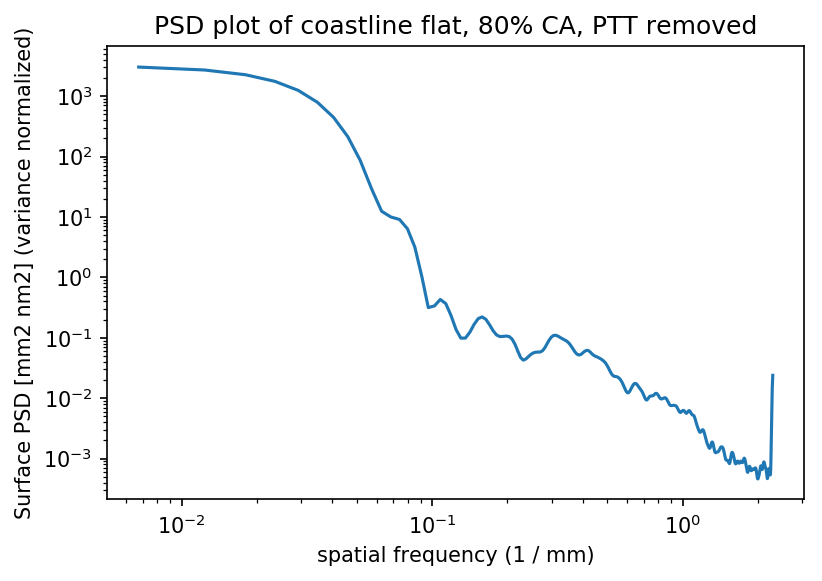

In [159]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
n_surf = 0
plt.figure(dpi=150)
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
#plt.loglog(kval_cf[n_surf,:], mean_psd_cf[n_surf,:])
plt.loglog(t_kval.value, t_mean_val.value)
plt.title('PSD plot of coastline flat, 80% CA, PTT removed')
plt.xlabel('spatial frequency ({})'.format(t_kval.unit))
plt.ylabel('Surface PSD [{}] (variance normalized)'.format(t_mean_val.unit)) 

In [2]:
# Test with the coastline flat
ntot_cf = 1 # goes from 1-8
D_full_cf = 50*u.mm
ca_80 = 80
oversamp_size = 4096
dr_width = 5
npix_diam_cf = []
var_cf = []

# open the optic surface
surf_loc = 'zygo_data/flat_mirrors/coastline_flat_correct.fits'
surf_data = fits.getdata(surf_loc)*u.um

# calculate the power optic data
(pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_cf, ca_80, oversamp_size)

# calculate the spatial frequency content
(delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_cf)

norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
np.sum(norm_psd) * (delta_k**2)

# calculate the PSD data from the variance-normalized PSD
(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)

print('Finished calculating PSD for surface {}'.format(ntest))
# if this is the first loop, initialize variables.
# There's gotta be a smarter way to do this.
if ntest == 0:
    kval_cf = np.zeros((ntot_cf, np.shape(kval)[0]))
    mean_psd_cf = np.zeros((ntot_cf, np.shape(mean_val)[0]))

kval_cf[ntest,:] = copy.copy(kval)
mean_psd_cf[ntest,:] = copy.copy(mean_val)
npix_diam_cf.append(npix_diam)
var_cf.append(ap_var)

NameError: name 'psd' is not defined

Finished calculating PSD for surface 0


Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

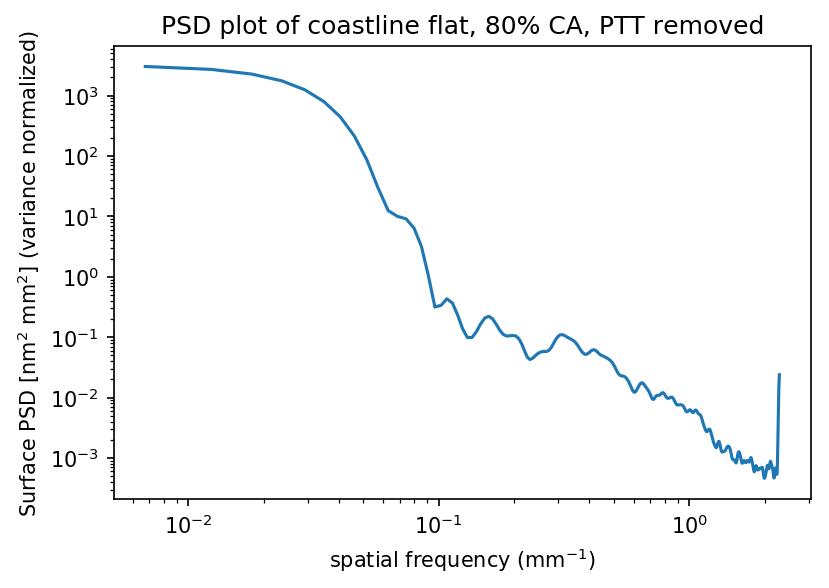

In [3]:
# Test with the coastline flat
ntot_cf = 1 # goes from 1-8
D_full_cf = 50*u.mm
ca_80 = 80
oversamp_size = 4096
dr_width = 5
npix_diam_cf = []
var_cf = []

for ntest in range(0,ntot_cf):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/coastline_flat_correct.fits'
    surf_data = fits.getdata(surf_loc)
    
    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_cf, ca_80, oversamp_size)
    
    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_cf)
    
    # normalize the PSD
    #norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
    norm_psd = psd.calc_measurePSD(pwr_opt, ap_var, delta_k)
    #new_psd = pwr_optic/np.sum(norm_psd)
    
    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
        
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_cf = np.zeros((ntot_cf, np.shape(kval)[0]))
        mean_psd_cf = np.zeros((ntot_cf, np.shape(mean_val)[0]))
    
    kval_cf[ntest,:] = copy.copy(kval)
    mean_psd_cf[ntest,:] = copy.copy(mean_val)
    npix_diam_cf.append(npix_diam)
    var_cf.append(ap_var)

# convert mean from mm^2 mm^2 to nm^2 mm^2
n_surf = 0
plt.figure(dpi=150)
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
#plt.loglog(kval_cf[n_surf,:], mean_psd_cf[n_surf,:])
plt.loglog(kval_cf[n_surf,:], [i*1e12 for i in mean_psd_cf[n_surf,:]])
plt.title('PSD plot of coastline flat, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [5]:
# 1 inch flats (8 total)

ca_80 = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm

# initialize variables
npix_diam_1 = []
var_1 = []
surf_pwr_1 = np.zeros((ntot_1, oversamp_size, oversamp_size))

print('Crunching individual PSDs for 1 inch flats ({} total mirrors)'.format(ntot_1))
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)*u.um*(u.mm/(1e3*u.um)) # set units and convert um to mm
    
    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)
    
    # normalize the PSD
    norm_psd = psd.calc_measurePSD(pwr_opt, ap_var, delta_k)
    
    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mean_psd_1 = np.zeros((ntot_1, np.shape(mean_val)[0]))
    
    kval_1[ntest,:] = copy.copy(kval)
    mean_psd_1[ntest,:] = copy.copy(mean_val)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)
    surf_pwr_1[ntest,:,:] = copy.copy(pwr_opt)

Crunching individual PSDs for 1 inch flats (8 total mirrors)
Finished calculating PSD for surface 0
Finished calculating PSD for surface 1
Finished calculating PSD for surface 2
Finished calculating PSD for surface 3
Finished calculating PSD for surface 4
Finished calculating PSD for surface 5
Finished calculating PSD for surface 6
Finished calculating PSD for surface 7


In [17]:
t_var = np.zeros((ntot_1))
t2_var = np.zeros((ntot_1))
var_set = np.zeros((ntot_1))
for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    surf_data = fits.getdata(surf_loc)
    
    # calculate the power optic data
    (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_80, oversamp_size)
    
    # calculate the spatial frequency content
    (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_80, D_full_1)
    
    # normalize the PSD the old way so it matches with the variance.
    t_psd = psd.calc_measurePSD(pwr_opt, ap_var, delta_k)
    t_var[ntest] = np.sum(t_psd)*(delta_k**2)
    
    # normalize it the new way and multiply by variance to see how that compares.
    t2_psd = psd.calc_normPSD(pwr_opt, delta_k) * ap_var
    t2_var[ntest] = np.sum(t2_psd)*(delta_k**2)
    
    # save the variance
    var_set[ntest] = ap_var

PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000


In [18]:
t_var

array([9.16865603e-12, 9.52341772e-12, 1.19600567e-11, 6.52244300e-12,
       7.26890213e-12, 1.04290430e-11, 4.98017726e-12, 9.20768791e-12])

In [20]:
var_set

array([9.16865603e-12, 9.52341772e-12, 1.19600567e-11, 6.52244300e-12,
       7.26890213e-12, 1.04290430e-11, 4.98017726e-12, 9.20768791e-12])

In [21]:
t2_var

array([9.16865603e-12, 9.52341772e-12, 1.19600567e-11, 6.52244300e-12,
       7.26890213e-12, 1.04290430e-11, 4.98017726e-12, 9.20768791e-12])

In [45]:
np.sqrt(var_set)

array([3.02797887e-06, 3.08600352e-06, 3.45833149e-06, 2.55390740e-06,
       2.69609016e-06, 3.22940288e-06, 2.23163108e-06, 3.03441723e-06])

In [27]:
# generate the averages
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)*1e6 # in nm from mm

# step 2: Make a collection of variance-normalized PSDs
delta_k = kval_1[ntest,1] - kval_1[ntest,0]
all_norm_psd_sets = np.zeros((ntot_1, oversamp_size, oversamp_size))
var_check = np.zeros((ntot_1))
for ntest in range(0, ntot_1):
    all_norm_psd_sets[ntest,:,:] = psd.calc_normPSD(surf_pwr_1[ntest, :, :],  delta_k)
    var_check[ntest] = np.sum(all_norm_psd_sets[ntest,:,:])*(delta_k**2)

var_check

PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000
PSD normalized: var=1.000


array([1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_1 = np.zeros((oversamp_size, oversamp_size))
for i in range(0,oversamp_size):
    for j in range(0,oversamp_size):
        avg_psd_1[i,j] = np.mean(all_norm_psd_sets[:,i,j])
np.sum(avg_psd_1)*(delta_k**2)

0.9999999999999979

In [29]:
avg_psd_2 = np.zeros((oversamp_size, oversamp_size))
for i in range(0,ntot_1):
    avg_psd_2 += all_norm_psd_sets[i,:,:]
avg_psd_2 /= ntot_1
np.sum(avg_psd_2)*(delta_k**2)

0.9999999999999979

In [30]:
# Step 4: scale the average PSD by the average of collection of individual variances in step 1
norm_psd = avg_psd_2 *avg_tot_var

# then calculate the radial profile
(avg_kval, avg_mean_psd) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)

In [31]:
(np.sum(norm_psd)*(delta_k**2)), avg_tot_var

(8.632547965036307e-12, 8.632547965036301e-12)

In [13]:
# generate the naive PSD average
nkval = np.shape(kval_1)[1]
easy_psd_1 = np.zeros(nkval)
for nk in range(0,nkval):
    easy_psd_1[nk] = np.mean(mean_psd_1[:,nk])

In [36]:
# generate part of the plot with all normalized PSDs
var_t1 = np.zeros((ntot_1))
for i in range(0, ntot_1):
    var_t1[i] = np.sum(all_norm_psd_sets[i,:,:])*(delta_k**2)
    
    # calculate the PSD data from the variance-normalized PSD
    (kval, mean_val) = psd.calc_radialPSD(all_norm_psd_sets[i,:,:], FT_freq, dr_width)
    
    print('Finished calculating normalized PSD for surface {}'.format(i))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if i == 0:
        kval_t1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mean_psd_t1 = np.zeros((ntot_1, np.shape(mean_val)[0]))
    
    kval_t1[i,:] = copy.copy(kval)
    mean_psd_t1[i,:] = copy.copy(mean_val)

Finished calculating normalized PSD for surface 0
Finished calculating normalized PSD for surface 1
Finished calculating normalized PSD for surface 2
Finished calculating normalized PSD for surface 3
Finished calculating normalized PSD for surface 4
Finished calculating normalized PSD for surface 5
Finished calculating normalized PSD for surface 6
Finished calculating normalized PSD for surface 7


In [37]:
var_t1

array([1., 1., 1., 1., 1., 1., 1., 1.])

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

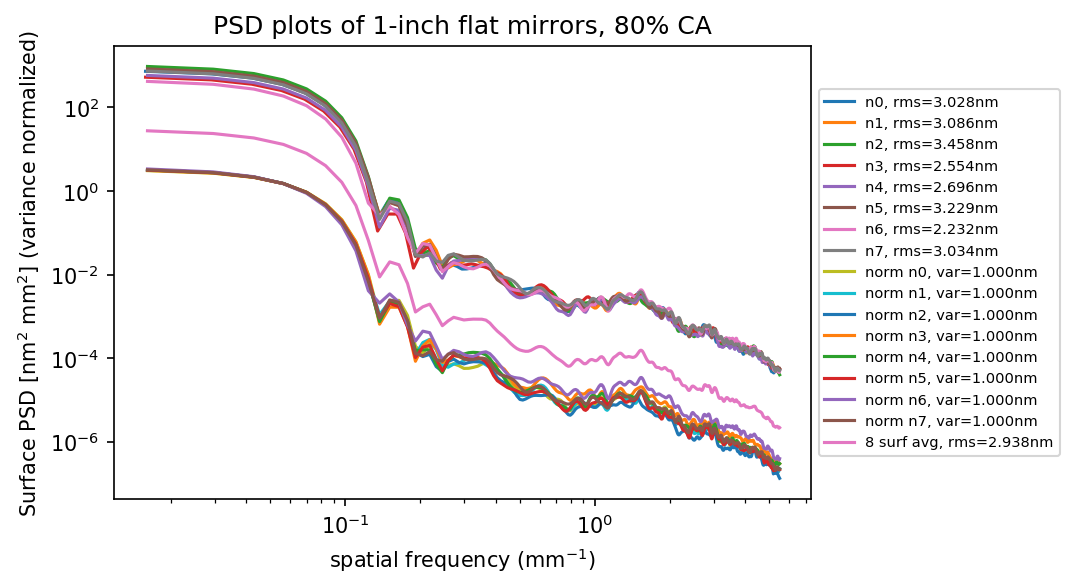

In [42]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
rms_t1 = np.sqrt(var_t1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
for ns in range(0,ntot_1):
    plt.loglog(kval_t1[ns,:], [i*1e12 for i in mean_psd_t1[ns,:]], label='norm n{}, var={:.3f}nm'.format(ns, var_t1[ns]))
plt.loglog(avg_kval, [i*1e12 for i in avg_mean_psd], label='{} surf avg, rms={:.3f}'.format(ntot_1, avg_tot_rms))
#plt.loglog(avg_kval, [i*1e12 for i in easy_psd_1], label='naive avg')
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [72]:
w=142*u.um
w

<Quantity 142. um>

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

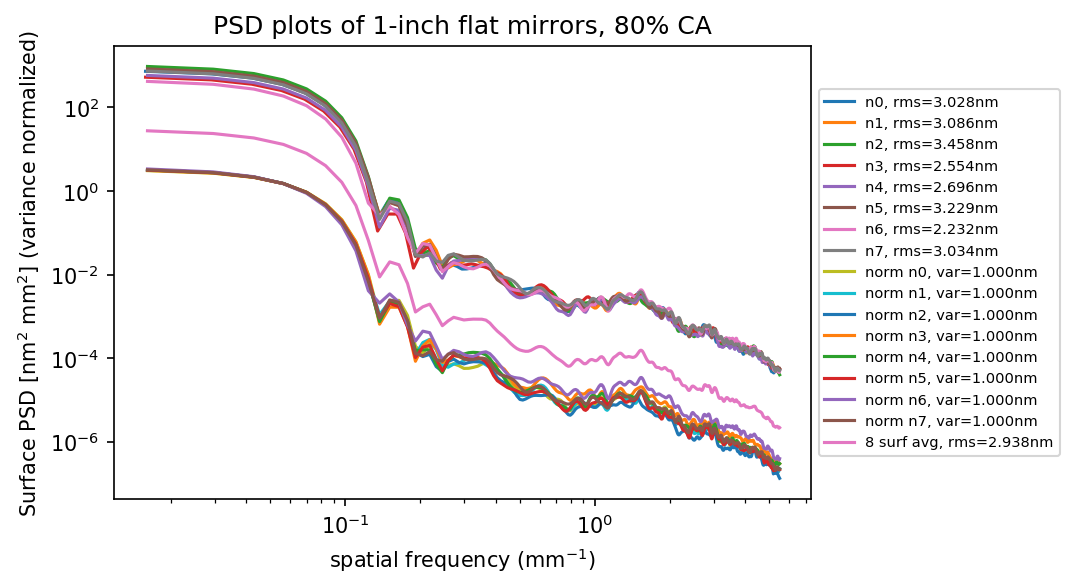

In [42]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
rms_t1 = np.sqrt(var_t1) # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
for ns in range(0,ntot_1):
    plt.loglog(kval_t1[ns,:], [i for i in mean_psd_t1[ns,:]], label='norm n{}, var={:.3f}nm'.format(ns, var_t1[ns]))
plt.loglog(avg_kval, [i*1e12 for i in avg_mean_psd], label='{} surf avg, rms={:.3f}'.format(ntot_1, avg_tot_rms))
#plt.loglog(avg_kval, [i*1e12 for i in easy_psd_1], label='naive avg')
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [65]:
mm2nm = (1*u.mm) / (1e6*u.nm)
1/mm2nm

<Quantity 1000000. nm / mm>

In [66]:
q= var_1 * u.mm * u.mm
q

<Quantity [9.16865603e-12, 9.52341772e-12, 1.19600567e-11, 6.52244300e-12,
           7.26890213e-12, 1.04290430e-11, 4.98017726e-12, 9.20768791e-12] mm2>

In [69]:
np.sqrt(q)

<Quantity [3.02797887e-06, 3.08600352e-06, 3.45833149e-06, 2.55390740e-06,
           2.69609016e-06, 3.22940288e-06, 2.23163108e-06, 3.03441723e-06] mm>

In [78]:
q.unit

Unit("mm2")

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

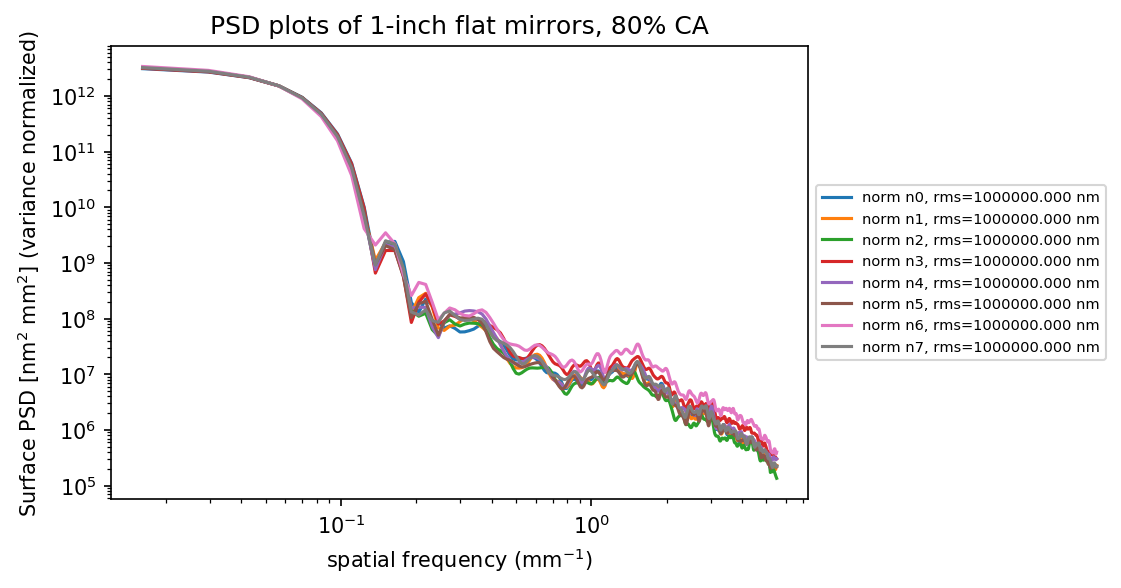

In [76]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1*u.mm*u.mm/(mm2nm*mm2nm)) # converts mm to nm
rms_t1 = np.sqrt(var_t1*u.mm*u.mm/(mm2nm*mm2nm)) # converts mm to nm
avg_tot_rms = np.sqrt(avg_tot_var*u.mm*u.mm/(mm2nm*mm2nm)) # in nm from mm
plt.figure(dpi=150)
#for ns in range(0,ntot_1):
#    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}'.format(ns, rms_1[ns]))
#plt.loglog(avg_kval, [i*1e12 for i in avg_mean_psd], label='{} surf avg, rms={:.3f}'.format(ntot_1, avg_tot_rms))
for ns in range(0,ntot_1):
    plt.loglog(kval_t1[ns,:], [i*1e12 for i in mean_psd_t1[ns,:]], label='norm n{}, rms={:.3f}'.format(ns, rms_t1[ns]))

#plt.loglog(avg_kval, [i*1e12 for i in easy_psd_1], label='naive avg')
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [49]:
# generate the averages
nkval = np.shape(kval_1)[1]

# step 1: Collect the individual surface variances and get the average
avg_tot_var = np.mean(var_1)
avg_tot_rms = np.sqrt(avg_tot_var)*1e6 # in nm from mm

# step 2: Make a collection of variance-normalized PSDs
all_norm_psd_sets = np.zeros((ntot_1, oversamp_size, oversamp_size))
for ntest in range(0, ntot_1):
    all_norm_psd_sets[ntest,:,:] = psd.calc_normPSD(surf_pwr_1[ntest, :, :], var_1[ntest], kval_1[ntest,1] - kval_1[ntest,0])

# Step 3: Take average of collection of variance-normalized PSDs
avg_psd_1 = np.zeros((oversamp_size, oversamp_size))
delta_k = kval_1[ntest,1] - kval_1[ntest,0]
for i in range(0,oversamp_size):
    for j in range(0,oversamp_size):
        avg_psd_1[i,j] = np.mean(all_norm_psd_sets[:,i,j])

# Step 4: scale the average PSD by the average of collection of individual variances in step 1
sf = (np.sum(avg_psd_1)*(delta_k**2))/avg_tot_var
norm_psd = avg_psd_1 * sf

# then calculate the radial profile
(avg_kval, avg_mean_psd) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)


In [54]:
# Step 4: scale the average PSD by the average of collection of individual variances in step 1
sf = (np.sum(avg_psd_1)*(delta_k**2))/avg_tot_var
norm_psd = avg_psd_1 * avg_tot_var

# then calculate the radial profile
(avg_kval, avg_mean_psd) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)

In [68]:
indiv_var = []
sf_set = []
for ntest in range(0, ntot_1):
    var_i = np.sum(all_norm_psd_sets[ntest,:,:])*(delta_k**2)
    sf_i = var_i/var_1[ntest]
    sf_set.append(sf_i)
    n_psd = all_norm_psd_sets[ntest,:,:]*sf_i
    indiv_var.append(np.sum(n_psd)*(delta_k**2))

In [72]:
sf_set

[1.0366942148760339,
 1.0000000000000024,
 0.9999999999999986,
 1.0366942148760334,
 0.9999999999999981,
 0.9999999999999968,
 1.0000000000000009,
 0.9999999999999988]

In [70]:
var_1

[9.168656034627703e-12,
 9.52341772332496e-12,
 1.1960056706198839e-11,
 6.522443002791295e-12,
 7.268902132709689e-12,
 1.0429042957816849e-11,
 4.980177257195722e-12,
 9.20768790562536e-12]

In [69]:
indiv_var

[9.85387458211019e-12,
 9.52341772332501e-12,
 1.1960056706198806e-11,
 7.009897096775256e-12,
 7.268902132709659e-12,
 1.042904295781678e-11,
 4.980177257195732e-12,
 9.207687905625335e-12]

In [60]:
var_1

[9.168656034627703e-12,
 9.52341772332496e-12,
 1.1960056706198839e-11,
 6.522443002791295e-12,
 7.268902132709689e-12,
 1.0429042957816849e-11,
 4.980177257195722e-12,
 9.20768790562536e-12]

In [63]:
np.sqrt(avg_tot_var)*1e6

2.938119801001365

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

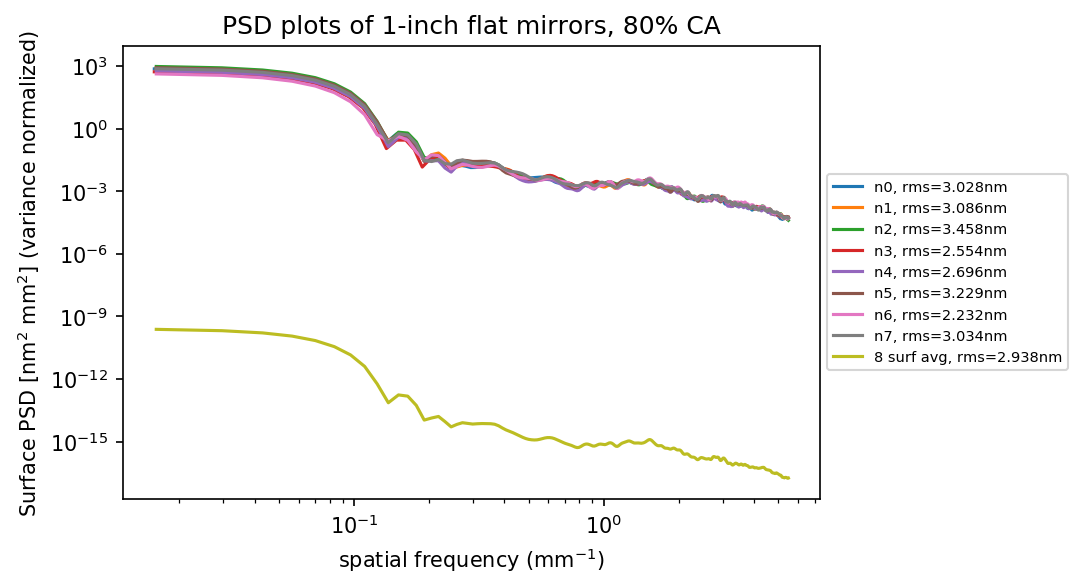

In [58]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
plt.loglog(avg_kval, [i*1e12 for i in avg_mean_psd], label='{} surf avg, rms={:.3f}nm'.format(ntot_1, avg_tot_rms))
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

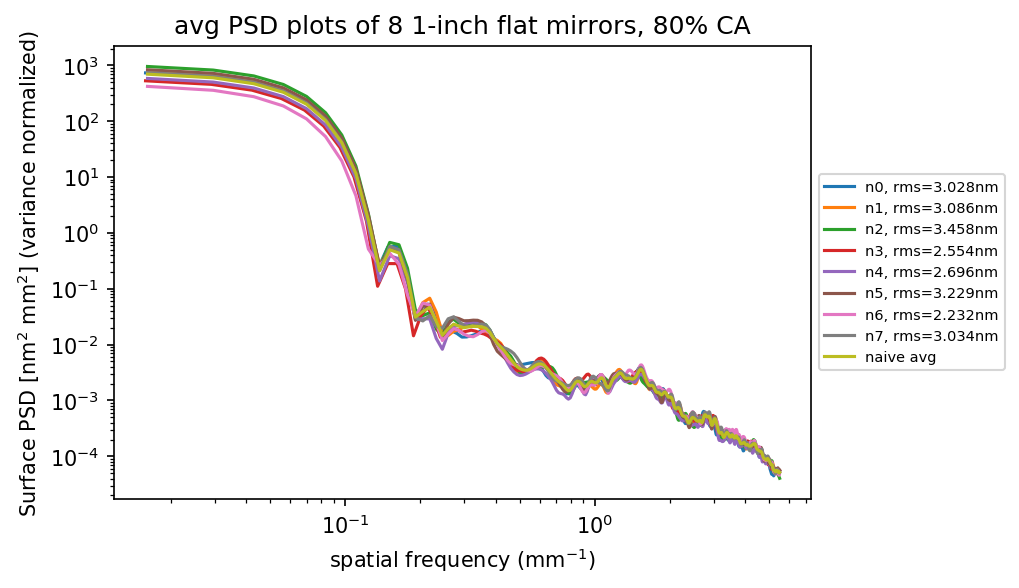

In [59]:
# generate the averages
nkval = np.shape(kval_1)[1]
easy_psd_1 = np.zeros(nkval)
for nk in range(0,nkval):
    easy_psd_1[nk] = np.mean(mean_psd_1[:,nk])
    
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
plt.loglog(avg_kval, [i*1e12 for i in easy_psd_1], label='naive avg')
plt.legend(prop={'size':7}, loc='center left',bbox_to_anchor=(1, 0.5))
plt.title('avg PSD plots of 8 1-inch flat mirrors, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

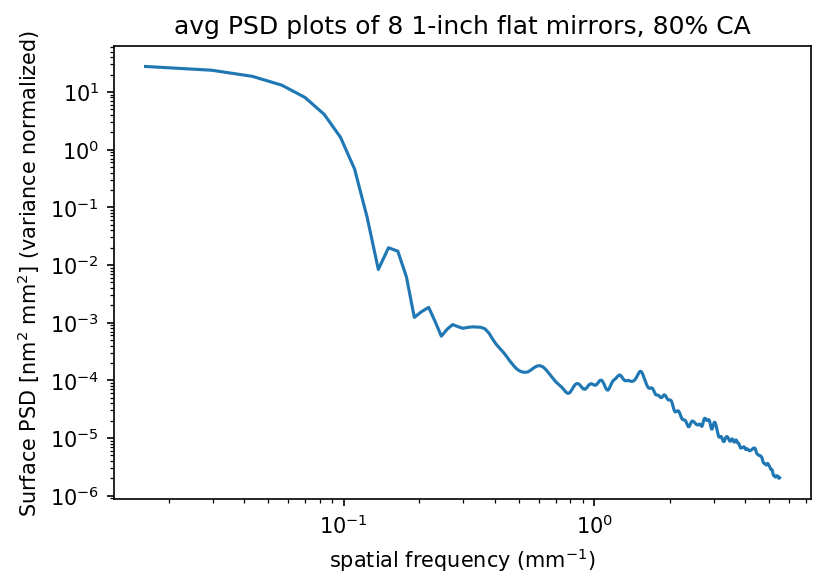

In [38]:
plt.figure(dpi=150)
plt.loglog(avg_kval, [i*1e12 for i in avg_mean_psd])
plt.title('avg PSD plots of 8 1-inch flat mirrors, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

ValueError: x and y must have same first dimension, but have shapes (408,) and (4096, 4096)

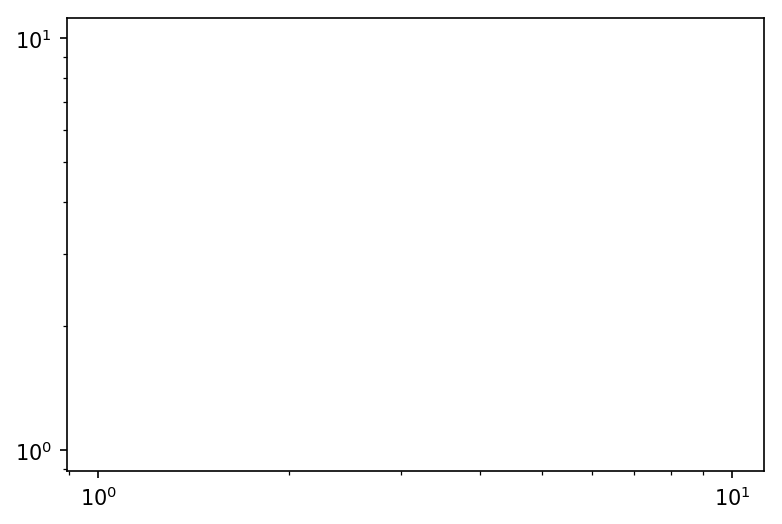

In [39]:
easy_avg = 

plt.figure(dpi=150)
plt.loglog(avg_kval, [i*1e12 for i in avg_psd_1])
plt.title('avg PSD plots of 8 1-inch flat mirrors, 80% CA')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [33]:
FT_freq

<Quantity [ 0.        ,  0.00269131,  0.00538263, ..., -0.00807394,
           -0.00538263, -0.00269131] pix / mm>

In [18]:
avg_tot_var

8.632547965036301e-12

In [13]:
# generate the averages
nkval = np.shape(kval_1)[1]
var_psd_1 = np.zeros(nkval)
sf_psd_1 = np.zeros(nkval)
norm_psd_1 = np.zeros(np.shape(mean_psd_1))
avg_psd_1 = np.zeros(nkval)
for nk in range(0,nkval):
    var_psd_1[nk] = np.var(mean_psd_1[:,nk])
    sf_psd_1[nk] = np.sum(mean_psd_1[:,nk])/var_psd_1[nk]
for ms in range(0,ntot_1):
    for nk in range(0,nkval):
        norm_psd_1[ms,nk] = mean_psd_1[ms,nk]/var_psd_1[nk]
for nk in range(0,nkval):
    avg_psd_1[nk] = np.mean(norm_psd_1[:,nk])


Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

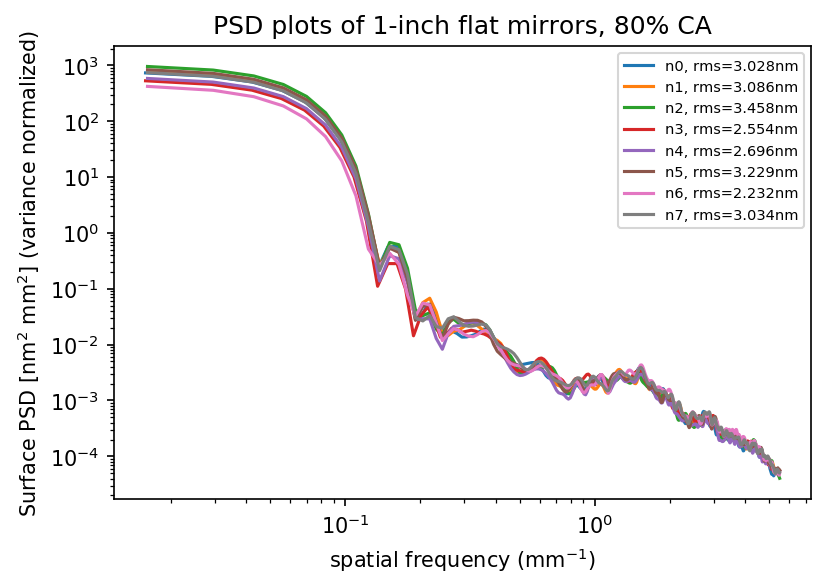

In [14]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
#plt.loglog(kval_1[0][:], alpha_fit, label='alpha={}'.format(alpha))
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

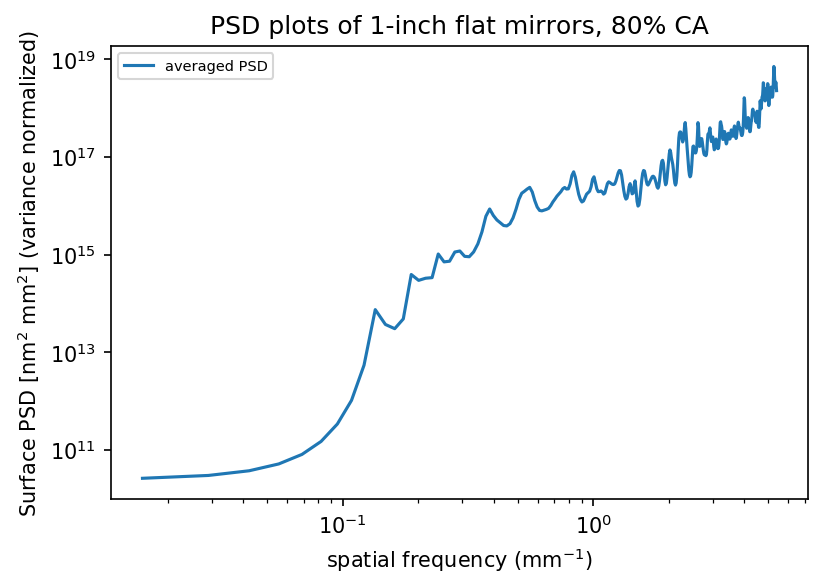

In [15]:
plt.figure(dpi=150)
plt.loglog(kval_1[0][:], avg_psd_1, label='averaged PSD')
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

In [10]:
np.shape(kval_1)[0]

8

## OLD CODE VERSION

In [9]:
# 1 inch flats (8 total)

ca_val = 80
dr_width = 5

ntot_1 = 8 # goes from 1-8
D_full_1 = 25.4*u.mm
npix_diam_1 = []
var_1 = []

print('Crunching PSDs for 1 inch flats (8 total mirrors)')

for ntest in range(0,ntot_1):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_1, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_1 = np.zeros((ntot_1, np.shape(kval)[0]))
        mean_psd_1 = np.zeros((ntot_1, np.shape(mean_val)[0]))
    
    kval_1[ntest,:] = copy.copy(kval)
    mean_psd_1[ntest,:] = copy.copy(mean_val)
    npix_diam_1.append(npix_diam)
    var_1.append(ap_var)

Crunching PSDs for 1 inch flats (8 total mirrors)
Finished calculating PSD for surface 0
Finished calculating PSD for surface 1
Finished calculating PSD for surface 2
Finished calculating PSD for surface 3
Finished calculating PSD for surface 4
Finished calculating PSD for surface 5
Finished calculating PSD for surface 6
Finished calculating PSD for surface 7


In [4]:
# 19mm flats (2 total)

ca_val = 80
dr_width = 5

ntot_19 = 2 # goes from 1-2
D_full_19 = 19*u.mm
npix_diam_19 = []
var_19 = []

print('Crunching PSDs for 19mm flats ({} total mirrors)'.format(ntot_19))

for ntest in range(0,ntot_19):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/19mm_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_19, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_19 = np.zeros((ntot_19, np.shape(kval)[0]))
        mean_psd_19 = np.zeros((ntot_19, np.shape(mean_val)[0]))
    
    kval_19[ntest,:] = copy.copy(kval)
    mean_psd_19[ntest,:] = copy.copy(mean_val)
    npix_diam_19.append(npix_diam)
    var_19.append(ap_var)

Crunching PSDs for 19mm flats (2 total mirrors)
Finished calculating PSD for surface 0
Finished calculating PSD for surface 1


In [5]:
# 0.5 inch flats (1 total)

ca_val = 80
dr_width = 5

ntot_05 = 1 # goes from 1
D_full_05 = 12.7*u.mm
npix_diam_05 = []
var_05 = []

print('Crunching PSDs for 0.5 inch flats ({} total mirrors)'.format(ntot_05))

for ntest in range(0,ntot_05):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/0p5in_n{}_mediansurface.fits'.format(ntest+1)
    
    # pass in the data for generating PSD content
    (kval, mean_val, npix_diam, ap_var) = psd.calc_PSD(surf_loc, D_full_05, ca_val, dr_width)
    
    print('Finished calculating PSD for surface {}'.format(ntest))
    # if this is the first loop, initialize variables.
    # There's gotta be a smarter way to do this.
    if ntest == 0:
        kval_05 = np.zeros((ntot_05, np.shape(kval)[0]))
        mean_psd_05 = np.zeros((ntot_05, np.shape(mean_val)[0]))
    
    kval_05[ntest,:] = copy.copy(kval)
    mean_psd_05[ntest,:] = copy.copy(mean_val)
    npix_diam_05.append(npix_diam)
    var_05.append(ap_var)

Crunching PSDs for 0.5 inch flats (1 total mirrors)
Finished calculating PSD for surface 0


## Build the PSD plots

In [17]:
npix_diam_1, npix_diam_05, npix_diam_19

([220, 220, 220, 220, 220, 220, 220, 220], [192], [168, 168])

In [19]:
np.shape(kval_1), np.shape(kval_05), np.shape(kval_19)

((8, 408), (1, 408), (2, 408))

In [28]:
for no in range(0,ntot_1):
    print('deltak at n{}: {}'.format(no,kval_1[0][1] - kval_1[0][0]))

deltak at n0: 0.013216273991141728
deltak at n1: 0.013216273991141728
deltak at n2: 0.013216273991141728
deltak at n3: 0.013216273991141728
deltak at n4: 0.013216273991141728
deltak at n5: 0.013216273991141728
deltak at n6: 0.013216273991141728
deltak at n7: 0.013216273991141728


In [25]:
alpha = 2
alpha_fit = 1/(kval_1[0][:]**alpha)

In [31]:
beta = np.zeros((ntot_1))
for ns in range(0,ntot_1):
    kmin = 1/(D_full_1.value*ca_val/100)
    kmax = 1/(2*D_full_1.value*(ca_val/100)/npix_diam_1[ns])
    beta[ns] = var_1[ns] / (2*np.pi * np.log(kmax/kmin) )
beta

array([3.16023293e-13, 3.03783599e-13, 3.81038900e-13, 2.25331885e-13,
       2.31614823e-13, 3.32070514e-13, 1.56813358e-13, 2.92517134e-13])

In [3]:
beta_avg1 = np.mean(beta)

kmin = 1/(D_full_1.value*ca_val/100)
kmax = 1/(2*D_full_1.value*(ca_val/100)/np.mean(npix_diam_1[ns]))
beta_avg2 = np.mean(var_1) / (2*np.pi * np.log(kmax/kmin) )

beta_avg1, beta_avg2

NameError: name 'beta' is not defined

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

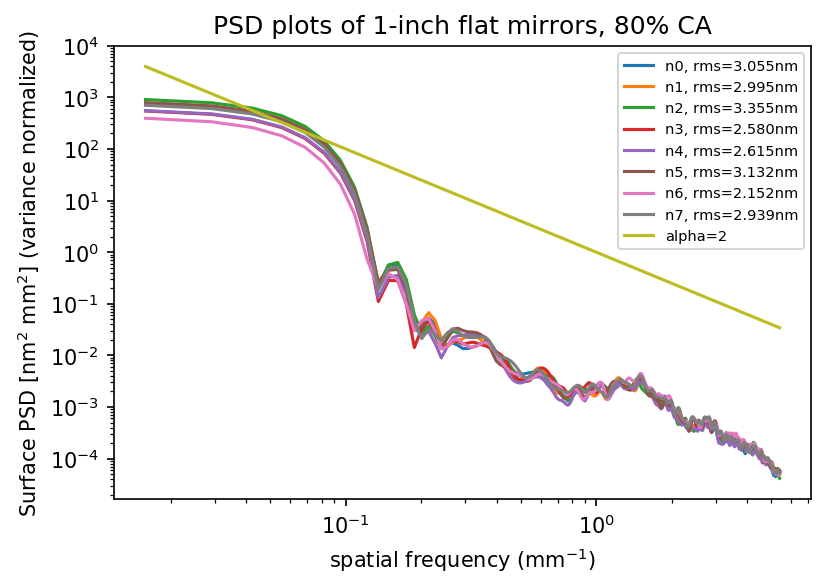

In [27]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_1[ns]))
plt.loglog(kval_1[0][:], alpha_fit, label='alpha={}'.format(alpha))
plt.title('PSD plots of 1-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

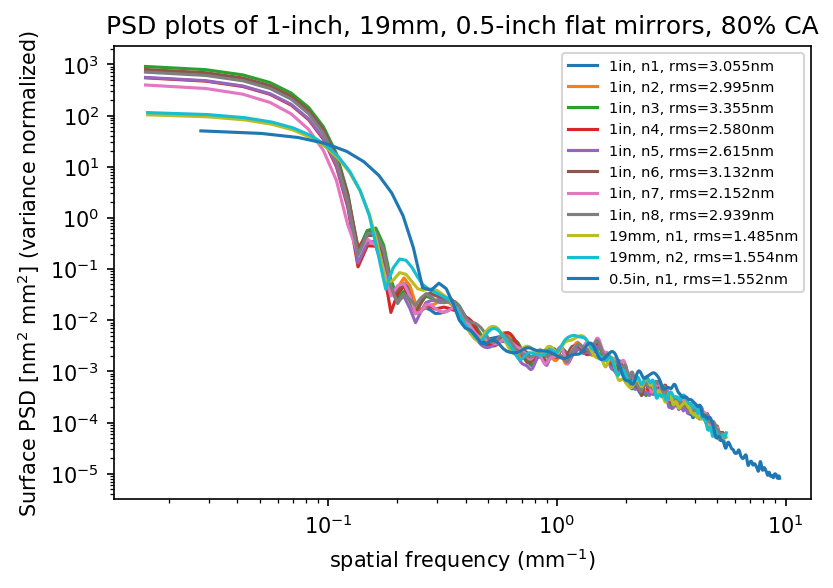

In [14]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt(var_1)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    plt.loglog(kval_1[ns,:], [i*1e12 for i in mean_psd_1[ns,:]], label='1in, n{}, rms={:.3f}nm'.format(ns+1, rms_1[ns]))
for ns in range(0,ntot_19):
    plt.loglog(kval_19[ns,:], [i*1e12 for i in mean_psd_19[ns,:]], label='19mm, n{}, rms={:.3f}nm'.format(ns+1, rms_19[ns]))
for ns in range(0,ntot_05):
    plt.loglog(kval_05[ns,:], [i*1e12 for i in mean_psd_05[ns,:]], label='0.5in, n{}, rms={:.3f}nm'.format(ns+1, rms_05[ns]))
plt.title('PSD plots of 1-inch, 19mm, 0.5-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

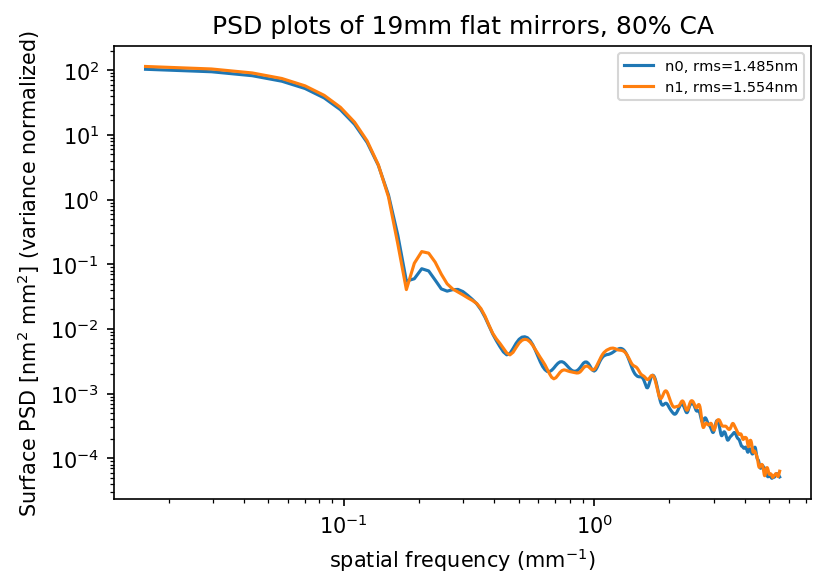

In [7]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_19 = np.sqrt(var_19)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_19):
    plt.loglog(kval_19[ns,:], [i*1e12 for i in mean_psd_19[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_19[ns]))
plt.title('PSD plots of 19mm flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

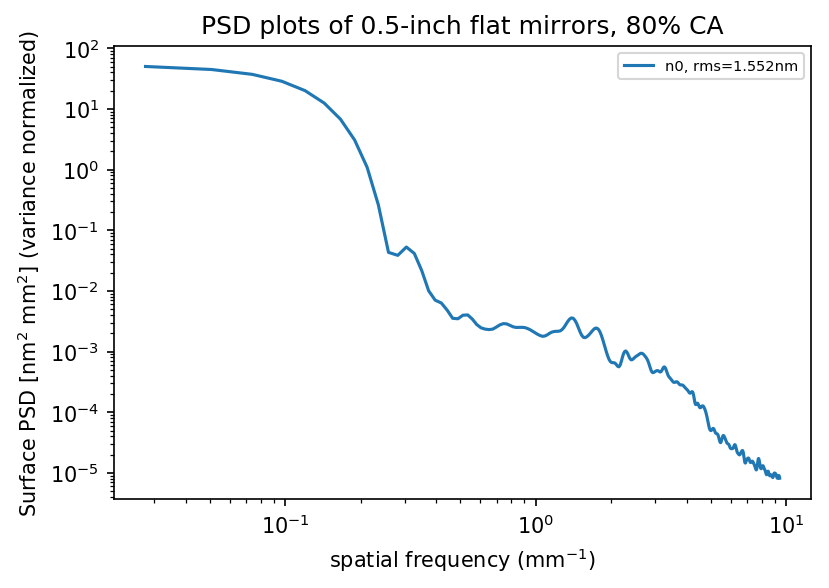

In [8]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_05 = np.sqrt(var_05)*1e6 # converts mm to nm
plt.figure(dpi=150)
for ns in range(0,ntot_05):
    plt.loglog(kval_05[ns,:], [i*1e12 for i in mean_psd_05[ns,:]], label='n{}, rms={:.3f}nm'.format(ns, rms_05[ns]))
plt.title('PSD plots of 0.5-inch flat mirrors, 80% CA')
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

## Investigating shapes of arrays
All content here is notes and nothing useful, maybe.

In [26]:
ntot_1in = 8 # goes from 1-8
data_shape_arr = []
new_optic_arr = []
for ntest in range(0,ntot_1in):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    
    # if the optics are not the same shape, cut down the edges of where there would be extra zeros.
    if np.shape(optic)[0] < np.shape(optic)[1]:
        diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
        new_optic = optic[:,np.int(diff/2):np.shape(optic)[1]-np.int(diff/2)]
    elif np.shape(optic)[0] > np.shape(optic)[1]:
        diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
        new_optic = optic[np.int(diff/2):np.shape(optic)[0]-np.int(diff/2),:]
    else:
        new_optic=optic
    
    new_optic_arr.append(np.shape(new_optic))


In [27]:
data_shape_arr

[(276, 276),
 (276, 280),
 (276, 280),
 (276, 276),
 (276, 280),
 (276, 280),
 (280, 276),
 (280, 276)]

In [28]:
new_optic_arr

[(276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276),
 (276, 276)]

In [24]:
surf_loc = 'zygo_data/flat_mirrors/median_combined/1in_n2_mediansurface.fits'.format(ntest+1)
optic, optic_header = fits.getdata(surf_loc, header=True)
np.shape(optic)

(276, 280)

In [25]:
if np.shape(optic)[0] < np.shape(optic)[1]:
    diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
    new_optic = optic[:,np.int(diff/2):np.shape(optic)[1]-np.int(diff/2)]
elif np.shape(optic)[0] > np.shape(optic)[1]:
    diff = np.int(np.abs(np.shape(optic)[0] - np.shape(optic)[1]))
    new_optic = optic[np.int(diff/2):np.shape(optic)[0]-np.int(diff/2),:]
else:
    new_optic=optic
np.shape(new_optic)

(276, 276)

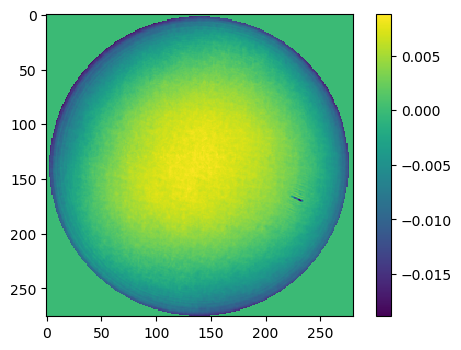

In [18]:
plt.figure(dpi=100)
plt.imshow(optic)
plt.colorbar()

In [19]:
optic_data = psd.zeroPadSquare(optic)
np.shape(optic_data)

(280, 280)

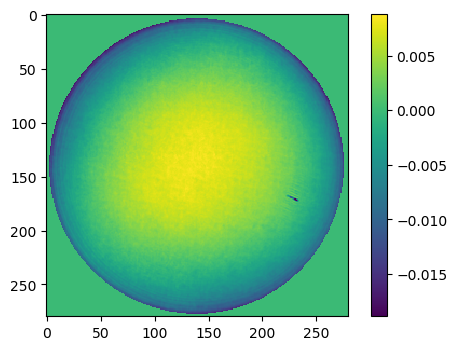

In [20]:
plt.figure(dpi=100)minimum
plt.imshow(optic_data)
plt.colorbar()

In [5]:
ntot_2in = 8 # goes from 1-8
data_shape_arr_2in = []
for ntest in range(0,ntot_2in):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/2in_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    data_shape_arr_2in.append(np.shape(optic))
data_shape_arr_2in

[(564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564),
 (564, 564)]

In [6]:
ntot_19mm = 2 # goes from 1-8
data_shape_arr_19mm = []
for ntest in range(0,ntot_19mm):
    # open the optic surface
    surf_loc = 'zygo_data/flat_mirrors/median_combined/19mm_n{}_mediansurface.fits'.format(ntest+1)
    optic, optic_header = fits.getdata(surf_loc, header=True)
    data_shape_arr_19mm.append(np.shape(optic))
data_shape_arr_19mm

[(212, 212), (212, 212)]

In [7]:
surf_loc = 'zygo_data/flat_mirrors/median_combined/0p5in_n1_mediansurface.fits'
optic, optic_header = fits.getdata(surf_loc, header=True)
np.shape(optic)

(240, 244)